In [4]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import timedelta, date

**1.** Загрузите данные за май 2016 года.

In [2]:
fileName = "yellow_tripdata_2016-06.csv"

In [5]:
taxi = pd.read_csv(fileName)


In [6]:
taxi.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-06-09 21:06:36,2016-06-09 21:13:08,2,0.79,-73.983360,40.760937,1,N,-73.977463,40.753979,2,6.0,0.5,0.5,0.00,0.0,0.3,7.30
1,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0.0,0.3,27.30
2,2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.26,-73.994316,40.751072,1,N,-74.004234,40.742168,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1,N,-73.929466,40.851540,1,26.0,0.5,0.5,1.00,0.0,0.3,28.30
4,2,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1,N,-73.985909,40.766445,1,13.5,0.5,0.5,2.96,0.0,0.3,17.76


In [7]:
taxi.shape

(11135470, 19)

**2.** Проведите фильтрацию: удалите поездки с

- нулевой длительностью
- нулевым количеством пассажиров
- нулевым расстоянием поездки по счётчику
- координатами начала, не попадающими в прямоугольник Нью-Йорка

Обработайте сырые данные по следующей схеме.

- Почистите данные от ошибок и аномалий.
- Отбросьте минуты и секунды во времени начала поездки.
- Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты. Разбейте этот прямоугольник на 2500 одинаковых прямоугольных областей — по 50 интервалов вдоль каждой оси.
- Посчитайте количество поездок за каждый час из каждой области. Не забудьте, что если в сырых данных для какой-то пары час-область нет ни одной записи, то в агрегированных данных для неё должен стоять 0.

In [8]:
# Нью-Йорк вписан в прямоугольник
West = -74.25559
East = -73.70001
South = 40.49612
North = 40.91553

In [9]:
taxi = taxi[(taxi.trip_distance != 0) & 
     (taxi.passenger_count != 0) & 
     (taxi.tpep_pickup_datetime != taxi.tpep_dropoff_datetime) &
    (taxi.pickup_longitude >= West) & (taxi.pickup_longitude <= East)  &
    (taxi.pickup_latitude >= South) & (taxi.pickup_latitude <= North)]

#taxi.dropna(inplace=True)

In [10]:
taxi['tpep_pickup_date_floor'] = pd.to_datetime(taxi.tpep_pickup_datetime).dt.floor('H')

In [11]:
taxi.shape

(10936046, 20)

В дальнейшем, когда вы будете предсказывать получившиеся ряды, нужно будет загружать ваши прогнозы на kaggle, поэтому нужно, чтобы идентификаторы ячеек были определены однозначно. В следующем файле даны идентификаторы ячеек, которые вам нужно использовать, и географические координаты их границ:

In [12]:
regions = pd.read_csv('regions.csv', sep=';')

In [13]:
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


Разбиваем записи поездок такси на 2500 одинаковых прямоугольных областей — по 50 интервалов вдоль каждой оси

In [14]:
def set_ceils(dataset, number_of_ceils=50, W=West, E=East, S=South, N=North):
    step_longitude = (E-W)/number_of_ceils
    step_latitude = (N-S)/number_of_ceils
    dataset['longitude_num'] = (np.floor((taxi.pickup_longitude - W) / step_longitude))
    dataset['latitude_num'] = (np.floor((taxi.pickup_latitude - S)/ step_latitude))
    dataset['region'] = dataset['longitude_num'] * number_of_ceils + dataset['latitude_num'] + 1

In [15]:
%%time
set_ceils(taxi)

taxi.drop(['longitude_num', 'latitude_num'], axis=1, inplace=True)

Wall time: 1.37 s


**3.** Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу

In [16]:
delta = (taxi['tpep_pickup_date_floor']-pd.to_datetime("2016-01-01 00:00:00", format='%Y-%m-%d %H:%M:%S'))
taxi['hours'] = delta.apply(lambda x: x.seconds/60/60 + 24*x.days)

In [17]:
min_hour = taxi['hours'].min()

In [18]:
num_regions = 2500
num_hours_in_month = pd.Period(str(taxi['tpep_pickup_date_floor'].min())).days_in_month * 24

bins_region = np.linspace(1, num_regions+1, num = num_regions+1)
bins_hours = np.linspace(min_hour, min_hour + num_hours_in_month, num = num_hours_in_month+1)

binned_statistic = stats.binned_statistic_2d(taxi.hours, 
                                             taxi.region, 
                                             None, 
                                             'count',
                                             bins=[bins_hours, bins_region])

In [19]:
stat_data = pd.DataFrame(binned_statistic.statistic, 
                         columns=np.arange(1,2501), 
                         index = pd.date_range(start = str(taxi['tpep_pickup_date_floor'].min()), periods = num_hours_in_month, freq = 'H'))

**4.** Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

- Столбцы - номера регионов
- Строки - номер часа (отсчитывая от 2016-05-01 00:00)  
- Значения - количество поездок

Полученная таблица:

In [33]:
stat_data.shape

(720, 2500)

In [61]:
stat_data.iloc[310:320][stat_data.columns[1528:1540]]

,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540
2016-06-13 22:00:00,0.0,6.0,2.0,7.0,10.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-06-13 23:00:00,0.0,6.0,1.0,9.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-14 00:00:00,0.0,5.0,4.0,15.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-14 01:00:00,0.0,7.0,2.0,21.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-06-14 02:00:00,0.0,3.0,1.0,2.0,11.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-06-14 03:00:00,0.0,3.0,1.0,4.0,7.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2016-06-14 04:00:00,1.0,9.0,2.0,3.0,11.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2016-06-14 05:00:00,0.0,23.0,0.0,4.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-06-14 06:00:00,1.0,24.0,2.0,7.0,14.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-06-14 07:00:00,2.0,43.0,2.0,5.0,13.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0


**5.** Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

In [19]:
#Longitude of Empire State Building -73.985664
#Latitude of Empire State Building: 40.748441
ESB_long = -73.985664
ESB_lat  =  40.748441

In [20]:
# Функция для получения номера региона по координатам 
def get_region(longitude, latitude, number_of_ceils=50):
    step_longitude = (East-West)/number_of_ceils
    step_latitude = (North-South)/number_of_ceils
    longitude_num = (np.floor((longitude - West) / step_longitude))
    latitude_num = (np.floor((latitude - South)/ step_latitude))
    return longitude_num * number_of_ceils + latitude_num + 1

In [21]:
ESB_reg = get_region(ESB_long, ESB_lat)

In [22]:
print("Номер региона содержащего Empire State Building: %d " % ESB_reg)

Номер региона содержащего Empire State Building: 1231 


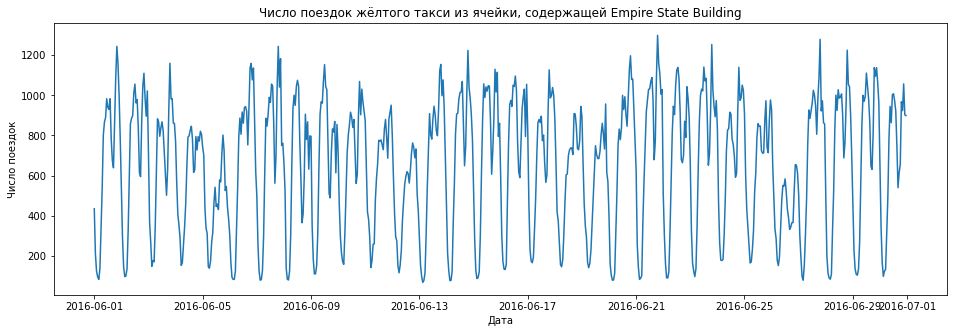

In [23]:
plt.figure(figsize=(16,5))
plt.plot(stat_data.index, stat_data.iloc[:, int(ESB_reg)-1])
plt.gca().set(xlabel = 'Дата', ylabel = 'Число поездок', title = 'Число поездок жёлтого такси из ячейки, содержащей Empire State Building')
plt.show()

**6.** Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [25]:
allvalues = stat_data.values.reshape(stat_data.shape[0] * stat_data.shape[1])
np.sum((allvalues == 0).astype(int))

1665094

In [26]:
stat_data.to_csv(fileName+"-agregated.csv",index=True)
